In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer


## EDA of cnn_dailymail

In [3]:
df_train = pd.read_csv('train.csv')
df_val = pd.read_csv('validation.csv')
df_train.sample(5)

,id,article,highlights
212190,9ec45221d17f028d2158bd345ec4b5f11a29458a,"LOS ANGELES, California (CNN) -- A boy playing...","""He admitted playing with matches and starting..."
210963,9d38fdb74227689dbb6e99bbd297201a2f4dd2bd,"By . Chris Pleasance . PUBLISHED: . 12:45 EST,...",Lucky was born blind and so kept bumping into ...
241174,c436a2157a6affca50edc01bf856c13061efed7c,By . Meghan Keneally . Last updated at 2:32 AM...,"Osbrany Montes De Oca, 20, enlisted with his b..."
102308,0fdb6c129c70d962cd85122907fb895e67f76932,(CNN) -- Bret has become the second tropical s...,Bret strengthens from a tropical depression to...
282147,f975e8d83bcbd2e4da4f72a764c9f1e011bba423,"FORT HOOD, Texas (CNN) -- The bumper sticker r...",Maj. Nidal Malik Hasan taunted for being a Mus...


In [4]:
df_train.shape

(287113, 3)

Let's make sure that 'id' is uniqe for each row, and then drop it

In [5]:
assert len(df_train.id.unique()) == df_train.shape[0]
df_train.drop(columns='id', inplace=True)
df_val.drop(columns='id', inplace=True)

One full sample from the dataset:

In [6]:
df_train.iloc[0, 0]

"By . Associated Press . PUBLISHED: . 14:11 EST, 25 October 2013 . | . UPDATED: . 15:36 EST, 25 October 2013 . The bishop of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A virus in late September and early October. The state Health Department has issued an advisory of exposure for anyone who attended five churches and took communion. Bishop John Folda (pictured) of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A . State Immunization Program Manager Molly Howell says the risk is low, but officials feel it's important to alert people to the possible exposure. The diocese announced on Monday that Bishop John Folda is taking time off after being diagnosed with hepatitis A. The diocese says he contracted the infection through contaminated food while attending a conference for newly ordained 

In [7]:
df_train.iloc[0, 1]

'Bishop John Folda, of North Dakota, is taking time off after being diagnosed .\nHe contracted the infection through contaminated food in Italy .\nChurch members in Fargo, Grand Forks and Jamestown could have been exposed .'

It is safe to say that for our porpose of summary the metadata of Auter and time of publition is not relevant.
TODO: clean metadata

In [8]:
for i in range(8):
    print(df_train.iloc[i, 0], '\n\n')

By . Associated Press . PUBLISHED: . 14:11 EST, 25 October 2013 . | . UPDATED: . 15:36 EST, 25 October 2013 . The bishop of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A virus in late September and early October. The state Health Department has issued an advisory of exposure for anyone who attended five churches and took communion. Bishop John Folda (pictured) of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A . State Immunization Program Manager Molly Howell says the risk is low, but officials feel it's important to alert people to the possible exposure. The diocese announced on Monday that Bishop John Folda is taking time off after being diagnosed with hepatitis A. The diocese says he contracted the infection through contaminated food while attending a conference for newly ordained b

I want to examine how the number of characters is distributed

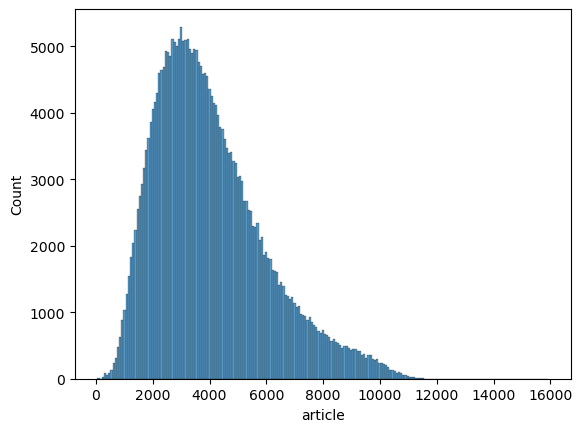

In [9]:
sns.histplot(x=df_train.article.apply(lambda x: len(x)));

there is very little around 0, I would like to check later that these numbers are not too low, and see if they are valid articles (maybe below 30)
we also have a long tail with a very high number of charters, and a very low number of samples in that area (above 12000)
Overall it is lightly right-skewed normally distributed, as expected.

let's see that number of words in each article is distributed in the same way:

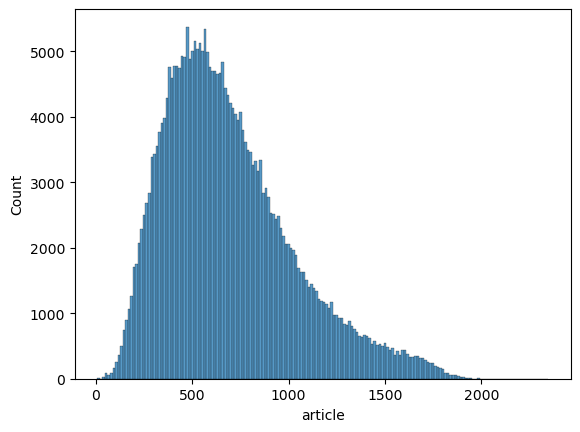

In [10]:
sns.histplot(x=df_train.article.apply(lambda x: len(x.split())));


Looks good.

## preprosseing

First we will tokenizing each artical into sentences

In [11]:
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize

artical = str(df_train.iloc[0, 0])
sentences = sent_tokenize(artical)
sentences

['By .',
 'Associated Press .',
 'PUBLISHED: .',
 '14:11 EST, 25 October 2013 .',
 '| .',
 'UPDATED: .',
 '15:36 EST, 25 October 2013 .',
 'The bishop of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A virus in late September and early October.',
 'The state Health Department has issued an advisory of exposure for anyone who attended five churches and took communion.',
 'Bishop John Folda (pictured) of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A .',
 "State Immunization Program Manager Molly Howell says the risk is low, but officials feel it's important to alert people to the possible exposure.",
 'The diocese announced on Monday that Bishop John Folda is taking time off after being diagnosed with hepatitis A.',
 'The diocese says he contracted the infection through contaminated food

## Models

### Random Model

This model takes randomly some sentences in the text to create the summary.



In [12]:
class RandomModel:
    def summarize(self, articles, threshold=0.2):
        result = []
        for article in articles:
            sentence_tokenized = sent_tokenize(article)
            num_sentences = int(threshold*len(sentence_tokenized))
            index_sentences_summary = np.sort(np.random.choice(len(sentence_tokenized), 
                                                               num_sentences, 
                                                               replace=False))
            summary = "".join(list(np.array(sentence_tokenized)[index_sentences_summary]))
            result.append(summary)
        return result

In [13]:
rm = RandomModel()
summaries = rm.summarize(df_train["article"].values)


In [14]:
summaries[0]

'15:36 EST, 25 October 2013 .The bishop of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A virus in late September and early October.Fargo Catholic Diocese in North Dakota (pictured) is where the bishop is located .'

### Weight Sentences Model

In [26]:
class WeightedModel:
    def create_dictionary_table(self, text_string) -> dict:
        # Removing stop words
        stop_words = set(stopwords.words("english"))
        
        words = word_tokenize(text_string)
        
        # Reducing words to their root form
        stem = PorterStemmer()
        
        # Creating dictionary for the word frequency table
        frequency_table = dict()
        for wd in words:
            wd = stem.stem(wd)
            if wd in stop_words:
                continue
            if wd in frequency_table:
                frequency_table[wd] += 1
            else:
                frequency_table[wd] = 1

        return frequency_table
    
    def calculate_weight(self, sentence, frequency_table):
        # the weight of a sentence is the sum of all the frequency of the words in it, divided by the lentgh of the sentence (num of words)
        words = word_tokenize(sentence)

        stem = PorterStemmer()

        weight = 0
        for wd in words:
            wd = stem.stem(wd)
            if wd not in frequency_table.keys():
                continue
            weight += frequency_table[wd]
        
        return weight/len(words)

    def summarize(self, articals, num_of_sentences=2):
        result = []
        for artical in articals:
            frequency_table = self.create_dictionary_table(artical)
            sentence_tokenized = sent_tokenize(artical)
            weights = [self.calculate_weight(sentence, frequency_table) for sentence in sentence_tokenized]
            idxs = np.argsort(weights)
            summary = "".join(list(np.array(sentence_tokenized)[idxs[:num_of_sentences]]))
            result.append(summary)
        return result


In [27]:
sub_df_train = df_train.sample(10000)
weight_m = WeightedModel()
summaries = weight_m.summarize(sub_df_train.article.values)
summaries[0]

"She said: 'She does all sorts of funny things like crawl in between the wolfhounds and you will just see a bit of cat poking out.'She runs to the door to greet people with the dogs, she eats the same food at the same time out of the same bowl and she follows the same routine."